In [1]:
## import json
import requests
import base64
import PIL.Image as Image
import cv2

# Early OCR service experiment

This notebook compares contains early tests of the tableparse service

In [2]:
api_entry_point = 'http://vision-tableparse.dev.allenai.org/v1/tableparse'
api_entry_point_local = 'http://0.0.0.0:8200/v1/tableparse'
header = {'Content-Type': 'application/json'}

def vision_tp_service(image, rq_attr):
    request_data = {
        rq_attr: image,
    }
    json_data = json.dumps(request_data)
    response = requests.post(api_entry_point, data=json_data, headers=header)
    json_response = json.loads(response.content.decode())
    if json_response:
        response = json_response
    return response

def draw_detections(img_path, tp_response, direction='rows'):
    colors = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (255, 255, 0),
        (0, 255, 255),
        (255, 0, 255),

        (128, 0, 0),
        (0, 128, 0),
        (0, 0, 128),
        (128, 128, 0),
        (0, 128, 128),
        (128, 0, 128),

        (255, 128, 0),
        (0, 128, 255),
        (128, 255, 0),
        (0, 255, 128),
        (255, 0, 128),
        (128, 0, 255)]
    
    image = cv2.imread(img_path)
    color_counter = 0
    for row in tp_response[direction]:
        color = colors[color_counter]
        for cell in row:
            start_x = cell['rectangle'][0]['x']
            start_y = cell['rectangle'][0]['y']
            end_x = cell['rectangle'][1]['x']
            end_y = cell['rectangle'][1]['y']
            cv2.rectangle(image, (start_x + 12, start_y + 1), (end_x - 1, end_y - 1), color=color, thickness=2)
        color_counter += 1
    return Image.fromarray(image)

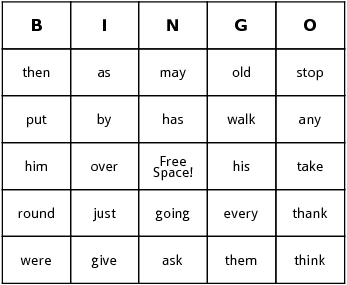

In [3]:
# set image path here
example_image_path = '/Users/schwenk/wrk/tableparse/vision-tableparse/examples/sight-word-bingo.png'
example_image_url = ''
b64_image = base64.b64encode(open(example_image_path, 'rb').read())

image_for_display = Image.open(example_image_path)
image_for_display

The service can take a url or b64 encoded image in a POST request

specify __'image' for b64encoded string__

or __'url' for url pointing to an image__

In [4]:
tp_response = vision_tp_service(b64_image, 'image')

service returns a dict of rows and columns, each as a list of cells

In [5]:
tp_response['columns'][0]

[{u'rectangle': [{u'x': 3, u'y': 3}, {u'x': 69, u'y': 47}], u'value': u'B'},
 {u'rectangle': [{u'x': 3, u'y': 50}, {u'x': 69, u'y': 94}],
  u'value': u'then'},
 {u'rectangle': [{u'x': 3, u'y': 97}, {u'x': 69, u'y': 141}],
  u'value': u'put'},
 {u'rectangle': [{u'x': 3, u'y': 144}, {u'x': 69, u'y': 188}],
  u'value': u'him'},
 {u'rectangle': [{u'x': 3, u'y': 191}, {u'x': 69, u'y': 234}],
  u'value': u'round'},
 {u'rectangle': [{u'x': 3, u'y': 237}, {u'x': 69, u'y': 281}],
  u'value': u'Were'}]

In [6]:
tp_response['rows'][0]

[{u'rectangle': [{u'x': 3, u'y': 3}, {u'x': 69, u'y': 47}], u'value': u'B'},
 {u'rectangle': [{u'x': 72, u'y': 3}, {u'x': 137, u'y': 47}], u'value': u''},
 {u'rectangle': [{u'x': 140, u'y': 3}, {u'x': 205, u'y': 47}], u'value': u'N'},
 {u'rectangle': [{u'x': 208, u'y': 3}, {u'x': 274, u'y': 47}], u'value': u'G'},
 {u'rectangle': [{u'x': 277, u'y': 3}, {u'x': 343, u'y': 47}], u'value': u'O'}]

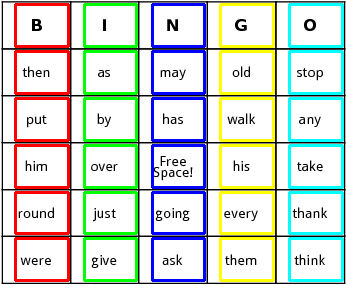

In [7]:
draw_detections(example_image_path, tp_response, 'columns') # could also pass 'rows' here

In [13]:
def make_cells(rows, cols, boxes):
    cells = [[[] for x in range(len(cols))] for y in range(len(rows))]
    for i,box in enumerate(boxes):
        sorted_rows = sorted(indices[i]['rows'])
        sorted_cols = sorted(indices[i]['cols'])
        for k,row_idx in enumerate(sorted_rows):
            for j,col_idx in enumerate(sorted_cols):
                if k == 0 and j == 0:
                    contents = {'type': 'cell', 'contents': box}
                else:
                    contents = {'type': 'span', 'main_row': sorted_rows[0], 'main_col': sorted_cols[0]}

                cells[row_idx][col_idx].append(contents)

    out_arr = [['' for x in range(len(cols))] for y in range(len(rows))]

    for row_idx, row in enumerate(cells):
        for col_idx, cell in enumerate(row):
            overall = []
            for cell_info in cell:
                if 'type' not in cell_info:
                    cell_info = {'type': 'unspecified'}

                if cell_info['type'] == 'cell':
                    contents = ' '.join(cell_info['contents'][4])
                elif cell_info['type'] == 'span':
                    # This can later be a special structure for the json
                    # including for the main cell, too
                    contents = 'SPAN_OF(' + str(cell_info['main_row']) + ', ' + str(cell_info['main_col']) + ')'
                else:
                    contents = ''
                overall.append(contents)
            display_contents = ' '.join(overall)
            out_arr[row_idx][col_idx] = display_contents
    return {'cells': out_arr}
#     with open(json_path, 'w') as f:
#         json.dump({'cells': out_arr}, f)